In [1]:
import os
import importlib.util

import numpy as np
import h5py
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt

from alad_mod.alad import ALAD
from evaluation.histogram_builder import *
from data.hlf_preprocessing import load

In [2]:
result_path = '/home/oliverkn/pro/alad_6021/2_l16'
model_file = 'model-10000000'

print('loading alad')

# loading config
spec = importlib.util.spec_from_file_location('config', os.path.join(result_path, 'config.py'))
config_alad = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_alad)

# loading preprocessor
preprocessor = load(os.path.join(result_path, 'preprocessor.pkl'))

# loading alad
tf.reset_default_graph()
ad = ALAD(config_alad, tf.Session())
ad.load(os.path.join(result_path, model_file))



loading alad


W1028 09:45:38.619307 140558040028992 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1028 09:45:38.669941 140558040028992 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:29: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1028 09:45:38.673120 140558040028992 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:44: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1028 09:45:38.674138 140558040028992 deprecation.py:323] From /home/oliverkn/pro/alad_6021/2_l16/config.py:81: dense (from tens

In [3]:
thres = 110
score_type = 'fm'

cont_bins = 40
settings_6021 = {}
settings_6021['HT'] = {'range': (0, 4000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['mass_jet'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['n_jet'] = {'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
settings_6021['n_bjet'] = {'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
settings_6021['lep_pt'] = {'range': (20, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['lep_eta'] = {'range': (-2.5, 2.5), 'yscale': 'linear', 'bins': cont_bins, 'int': False}
settings_6021['lep_charge'] = {'range': (-1, 1), 'yscale': 'linear', 'int': True}
settings_6021['lep_iso_ch'] = {'range': (0, 0.4), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['lep_iso_neu'] = {'range': (0, 0.4), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['lep_iso_gamma'] = {'range': (0, 0.4), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['MET'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['METo'] = {'range': (-100, 100), 'yscale': 'linear', 'bins': cont_bins, 'int': False}
settings_6021['METp'] = {'range': (-100, 100), 'yscale': 'linear', 'bins': cont_bins, 'int': False}
settings_6021['MT'] = {'range': (0, 200), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['n_mu'] = {'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
settings_6021['pt_mu'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['mass_mu'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['n_ele'] = {'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
settings_6021['pt_ele'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['mass_ele'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['n_neu'] = {'range': (0, 400), 'yscale': 'linear', 'int': True, 'bin_size': 1}
settings_6021['n_ch'] = {'range': (0, 1000), 'yscale': 'linear', 'int': True, 'bin_size': 1}
settings_6021['n_photon'] = {'range': (0, 1000), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings = settings_6021

def pre_select(x):
    filter_eta = np.abs(x[:,5]) < 0.8
    filter_njets = x[:,2] > 1
    #filter_ht = x[:,0] < 600
    filter_iso = x[:,7] < 0.1
    filter_idx = filter_njets * filter_eta * filter_iso
    
    return x[filter_idx]

def anomaly_select(x):
    x_transformed = preprocessor.transform(x)
    scores = ad.get_anomaly_scores(x_transformed, type=score_type)
    anomaly_idx = scores > thres
    return x[anomaly_idx]

def post_select(x):
    filter_bjets =  x[:,3] > 1
    filter_idx = filter_bjets 
    
    return x[filter_idx]

def build_hists(x, n_max, batch_size=2 ** 20):
    builder_raw = HistogramBuilder(hist_settings)
    builder_pre = HistogramBuilder(hist_settings)
    builder_ano= HistogramBuilder(hist_settings)
    builder_pos = HistogramBuilder(hist_settings)

    n = x.shape[0]
    n = min(n, n_max)
    #sample_fraction = min(n_max/n, 1)
    #sample_size = int(batch_size*sample_fraction)

    n_batches = int(n / batch_size) + 1
    for t in range(n_batches):
        print('batch number ' + str(t))
        ran_from = int(t * batch_size)
        ran_to = (t + 1) * batch_size
        ran_to = int(np.clip(ran_to, 0, n))
        x_raw = x[ran_from:ran_to]
        
        #if sample_fraction < 0.5:
        #    idx = np.arange(0,batch_size)
        #    idx = np.random.choice(idx, sample_size, replace=False)
        #    x_raw = x_batch[idx]
        #else:
        #    x_raw = x_batch
        
        
        # raw
        builder_raw.add_data(x_raw)
        
        # pre selection
        x_pre = pre_select(x_raw)
        builder_pre.add_data(x_pre)
        
        # anomaly selection
        x_ano = anomaly_select(x_pre)
        builder_ano.add_data(x_ano)
        
        # post selection
        x_pos = post_select(x_ano)
        builder_pos.add_data(x_pos)
        
    return builder_raw.get_histogram_data(), builder_pre.get_histogram_data(),\
           builder_ano.get_histogram_data(), builder_pos.get_histogram_data()

In [8]:
#compute hist for raw, pres, ad, pos

n_max = int(10e5)

# data
lum = 4429.0
lum = lum * 2.74

sets = {}
sets['dy1jets'] = {'file': '/home/oliverkn/pro/7719/data.hdf5', 'xsec':561, 'K':1.23, 'N_tot':65949083}
sets['dy2jets'] = {'file': '/home/oliverkn/pro/7721/data.hdf5', 'xsec':181, 'K':1.23, 'N_tot':21732511}
sets['dy3jets'] = {'file': '/home/oliverkn/pro/7722/data.hdf5', 'xsec':51, 'K':1.23, 'N_tot':11025803}
sets['dy4jets'] = {'file': '/home/oliverkn/pro/7723/data.hdf5', 'xsec':15, 'K':1.23, 'N_tot':6361350}

#sets['w1jets'] = {'file': '/home/oliverkn/pro/9863/data.hdf5', 'xsec':4480, 'K':1.23, 'N_tot':29784800}
sets['w1jets'] = {'file': '/home/oliverkn/pro/9863/data_j_eta_part.hdf5', 'xsec':4480, 'K':1.23, 'N_tot':2978480}
sets['w2jets'] = {'file': '/home/oliverkn/pro/9864/data.hdf5', 'xsec':1435, 'K':1.23, 'N_tot':30693853}
sets['w3jets'] = {'file': '/home/oliverkn/pro/9865/data.hdf5', 'xsec':304, 'K':1.23, 'N_tot':15241144}

sets['ttbar'] = {'file': '/home/oliverkn/pro/9588/data.hdf5', 'xsec':164, 'K':1.66, 'N_tot':62131965}

sets['data'] = {'file': '/home/oliverkn/pro/6021/data.hdf5', 'xsec':1, 'K':1, 'N_tot':lum}


for key, set in sets.items():
    print('------------------------------building ' + key)
    
    # load data
    file = set['file']
    x = h5py.File(file, 'r')['data']
    
    # build hists
    hist_raw, hist_pre, hist_ano, hist_pos = build_hists(x, n_max=n_max)
    
    n_events = hist_raw['HT'].n
    n_events_a = hist_ano['HT'].n
    print('%d / %d = %3d_ppm' % (n_events_a, n_events, (n_events_a / n_events*1e6)))
    
    # weight
    fraction_processed = n_events/x.shape[0]
    print('processed/available: %d/%d = %f'%(n_events, x.shape[0],fraction_processed))
    
    N_tot = set['N_tot']
    N_target = lum * set['K'] * set['xsec']
    weight =  N_target / (N_tot * fraction_processed)
    print('N_tot=%d, N_target=%d, w=%f'%(N_tot, N_target, weight))
    
    # scaling up hists
    hist_raw = scale_hists(hist_raw, weight)
    hist_pre = scale_hists(hist_pre, weight)
    hist_ano = scale_hists(hist_ano, weight)
    hist_pos = scale_hists(hist_pos, weight)
    
    set['hist_raw'] = hist_raw
    set['hist_pre'] = hist_pre
    set['hist_ano'] = hist_ano
    set['hist_pos'] = hist_pos

------------------------------building dy1jets
batch number 0
115 / 1000000 = 115_ppm
processed/available: 1000000/18911952 = 0.052877
N_tot=65949083, N_target=8373831, w=2.401330
------------------------------building dy2jets
batch number 0
221 / 1000000 = 221_ppm
processed/available: 1000000/6491172 = 0.154055
N_tot=21732511, N_target=2701717, w=0.806962
------------------------------building dy3jets
batch number 0
583 / 1000000 = 583_ppm
processed/available: 1000000/3401866 = 0.293956
N_tot=11025803, N_target=761257, w=0.234876
------------------------------building dy4jets
batch number 0
2172 / 1000000 = 2172_ppm
processed/available: 1000000/2018671 = 0.495375
N_tot=6361350, N_target=223899, w=0.071051
------------------------------building w1jets
batch number 0
22 / 618350 =  35_ppm
processed/available: 618350/618350 = 1.000000
N_tot=2978480, N_target=66871238, w=22.451465
------------------------------building w2jets
batch number 0
151 / 1000000 = 151_ppm
processed/available: 100

In [9]:
sum_n = 0
for key in ['w1jets', 'w2jets', 'w3jets', 'dy1jets', 'dy2jets', 'dy3jets', 'dy4jets', 'ttbar']:
    n = sets[key]['hist_raw']['HT'].n
    sum_n += n
    

for key in ['w1jets', 'w2jets', 'w3jets', 'dy1jets', 'dy2jets', 'dy3jets', 'dy4jets', 'ttbar']:
    n = sets[key]['hist_raw']['HT'].n
    print('%s: %d (%f)'%(key, n, n/sum_n))
    
print('total number of events: %d' % sum_n)
print('total number of events: %d' % sets['data']['hist_raw']['HT'].n)

w1jets: 13882863 (0.592225)
w2jets: 4503212 (0.192101)
w3jets: 969544 (0.041360)
dy1jets: 2401329 (0.102438)
dy2jets: 806962 (0.034424)
dy3jets: 234875 (0.010020)
dy4jets: 71050 (0.003031)
ttbar: 572034 (0.024402)
total number of events: 23441873
total number of events: 38247438


In [10]:
hist_type_dict = {}
for hist_type in ['hist_raw', 'hist_pre', 'hist_ano','hist_pos']:
    hist_proc_dict = {}
    for proc in ['w1jets', 'w2jets', 'w3jets', 'dy1jets', 'dy2jets', 'dy3jets', 'dy4jets', 'ttbar']:
        #hist_proc_scaled = scale_hists(sets[proc][hist_type], sets[proc]['weight'])
        hist_proc = sets[proc][hist_type]
        hist_proc_dict[proc] = hist_proc
    hist_type_dict[hist_type]=hist_proc_dict

hist_type_dict_compressed = {}
for hist_type in ['hist_raw', 'hist_pre', 'hist_ano','hist_pos']:
    hist_proc = hist_type_dict[hist_type]
    hist_proc_dict = {}
    
    # sum W
    hist_w_list = [hist_proc[proc] for proc in ['w1jets', 'w2jets', 'w3jets']]
    hist_w = sum_hists(hist_w_list, [1,1,1])
    hist_proc_dict['W'] = hist_w
    
    #sum DY
    hist_dy_list = [hist_proc[proc] for proc in ['dy1jets', 'dy2jets', 'dy3jets', 'dy4jets']]
    hist_dy = sum_hists(hist_dy_list, [1,1,1,1])
    hist_proc_dict['DY'] = hist_dy
    
    # ttbar
    hist_proc_dict['tt'] = hist_proc['ttbar']
    
    # add to type dict
    hist_type_dict_compressed[hist_type]=hist_proc_dict

data_hist_type_dict={}
for hist_type in ['hist_raw', 'hist_pre', 'hist_ano','hist_pos']:
    data_hist_type_dict[hist_type] = sets['data'][hist_type]

In [11]:
#print event numbers
for hist_type in ['hist_raw', 'hist_pre', 'hist_ano','hist_pos']:
    print('---------------------%s---------------------' % hist_type)
    n_mc = 0
    for proc in ['W', 'DY', 'tt']:
        n = hist_type_dict_compressed[hist_type][proc]['HT'].n
        n_mc += n
        print('%s/%s total events: %d' %(hist_type, proc, n))
    
    n_data = data_hist_type_dict[hist_type]['HT'].n
    print('n_data/n_mc: %d/%d = %f'%(n_data, n_mc, n_data/n_mc))

---------------------hist_raw---------------------
hist_raw/W total events: 19355619
hist_raw/DY total events: 3514218
hist_raw/tt total events: 572034
n_data/n_mc: 38247438/23441873 = 1.631586
---------------------hist_pre---------------------
hist_pre/W total events: 5016385
hist_pre/DY total events: 1087742
hist_pre/tt total events: 269284
n_data/n_mc: 6809497/6373412 = 1.068423
---------------------hist_ano---------------------
hist_ano/W total events: 1401
hist_ano/DY total events: 745
hist_ano/tt total events: 1544
n_data/n_mc: 2792/3692 = 0.756247
---------------------hist_pos---------------------
hist_pos/W total events: 70
hist_pos/DY total events: 26
hist_pos/tt total events: 748
n_data/n_mc: 267/845 = 0.316831


saving fig to hists.pdf


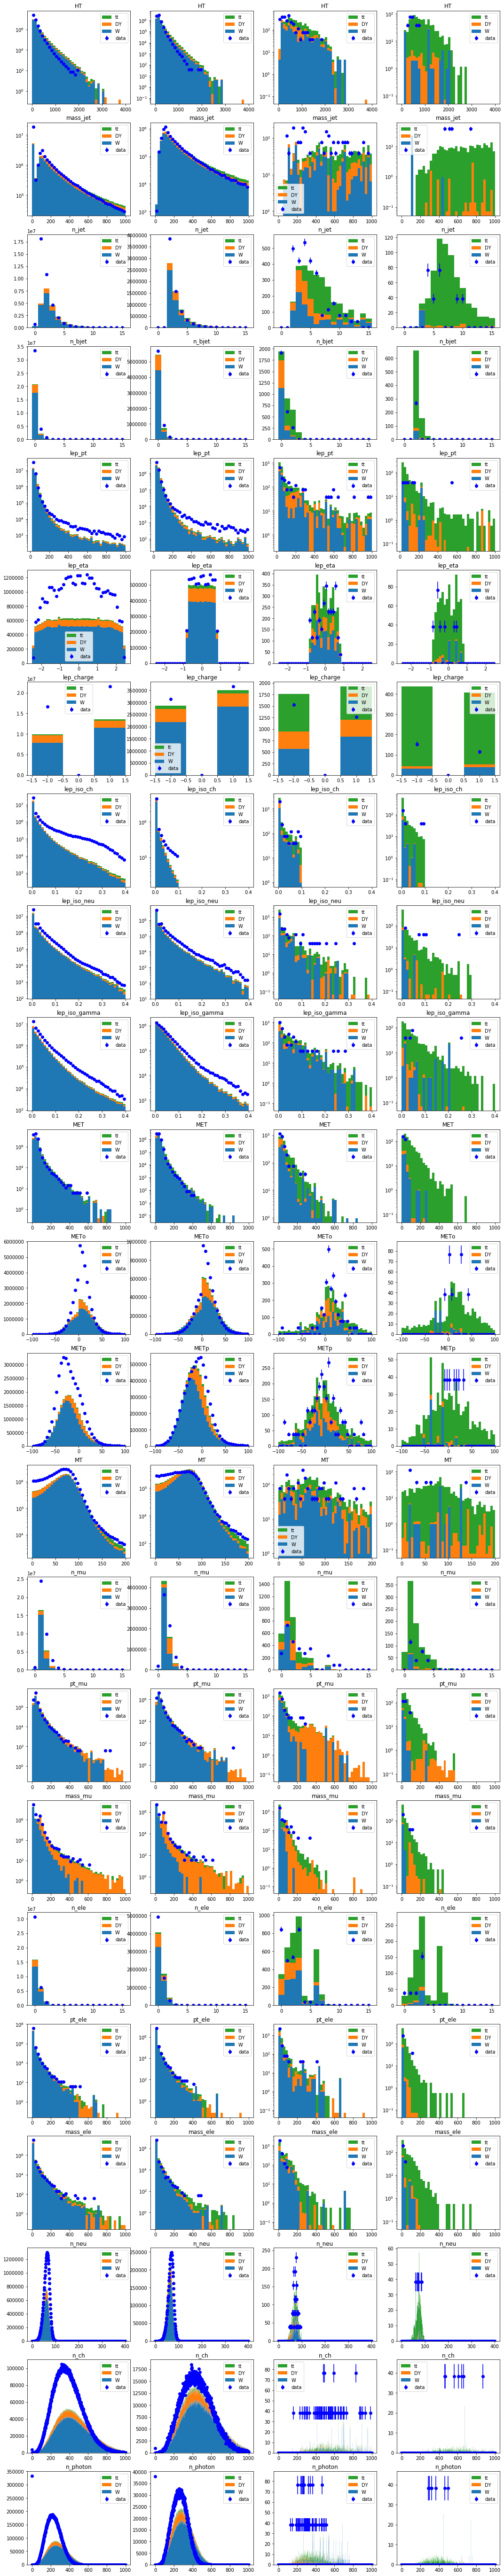

In [12]:
#hist_data_list[hist_type][proc][feature]
#hist_data_type_dict[hist_type][feature]
def plot_hist(hist_data_list, hist_data_type_dict, settings, output_file=None, all_lin=False):
    f, ax_arr = plt.subplots(23, len(hist_data_list.keys()), figsize=(18, 100))

    for col, hist_type in enumerate(hist_data_list.keys()):
    
        for row, feature in enumerate(settings.keys()):
            ax = ax_arr[row, col]
            fsettings = settings[feature]

            x_list = []
            bin_edges = None
            weights_list = []
            
            for proc, hist in hist_data_list[hist_type].items():
                bin_edges = hist[feature].bin_edges
                x_list.append(hist[feature].bin_edges[:-1])
                weights_list.append(hist[feature].bin_content)
            
            ax.hist(x_list, bin_edges, weights=weights_list,stacked=True, label=hist_data_list[hist_type].keys(), histtype='stepfilled')

            # plot data
            hist_data_f = hist_data_type_dict[hist_type][feature]
            bin_centers = (hist_data_f.bin_edges[:-1]+hist_data_f.bin_edges[1:])/2
            ax.errorbar(bin_centers, hist_data_f.bin_content, yerr=np.sqrt(hist_data_f.bin_content), fmt='bo', label='data')
            
            if all_lin is False:
                ax.set_yscale(fsettings['yscale'])
                
            ax.set_title(feature)
            ax.legend()

    if output_file is not None:
        print('saving fig to ' + output_file)
        plt.savefig(output_file)

    plt.show()
    
plot_hist(hist_type_dict_compressed,data_hist_type_dict, hist_settings, output_file='hists.pdf')

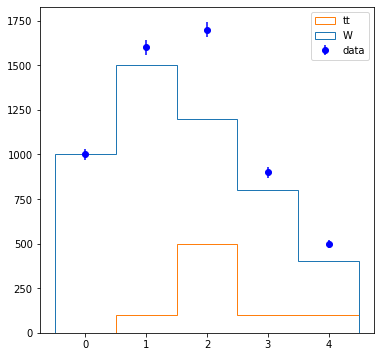

In [15]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

w = np.array([10,15,12,8,4])*100
tt = np.array([0, 1, 5, 1, 1])*100
data = w + tt

bin_edges = np.arange(0, 6)-0.5

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

ax.hist([bin_edges[:-1]]*2, bin_edges, weights=[w, tt], label=['W', 'tt'],stacked=False, histtype='step')
ax.errorbar(bin_centers, data, yerr=np.sqrt(data), fmt='bo', label='data')

ax.legend()

plt.show()

In [ ]:
x = h5py.File('/home/oliverkn/pro/7719/data.hdf5', 'r')['data']

x_batch = x[:1000000]

a = np.arange(0,1000000)
s = np.random.choice(a, 10000, replace=False)
print(x_batch[s].shape)


In [ ]:
bin_edges = np.arange(0, 1 + 2) - 0.5
print(bin_edges)